In [65]:
import pickle
from pathlib import Path
import numpy as np
import statistics
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *

In [66]:
import os
import pickle
import numpy as np
import pandas as pd
from IPython.display import display  # Ensure this is not overwritten elsewhere


def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data

def read_jax_file(file_path, gate_name):
    """
    Load and extract relevant data from a pickle file.
    
    Assumes the pickle file contains a dictionary with keys:
      - 'costs'
      - 'grads_per_epoch'
      - 'avg_fidelity'
      - 'controls'
      - 'reservoirs'
      - 'trotter_step'
      - 'testing_results'
      - 'QFIM Results'
    
    The 'QFIM Results' value is a dict with keys:
      - "qfim_eigvals"
      - "trainable_params"
      - "qfim"
      - "entropy"
      - "variance"
      - "trace"
    
    Parameters:
      file_path (str or Path): Path to the pickle file.
      gate_name (str): The name of the gate (taken from the folder name) to store.
      
    Returns:
      dict: A dictionary containing:
            - 'costs': array of costs,
            - 'fidelity': average fidelity (float),
            - 'num_params': number of parameters,
            - 'test_results': array of testing results,
            - 'grads_per_epoch': list of gradient arrays,
            - 'qfim_stats': dict of QFIM metrics,
            - 'gate': the provided gate name.
    """
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    df = clean_array(df)
    
    try:
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
    except Exception as e:
        print(f"Error reading costs from {file_path}: {e}")
        costs = None
        
    try:
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]
    except Exception as e:
        print(f"Error reading grads_per_epoch from {file_path}: {e}")
        grads_per_epoch = None
        
    try:
        fidelity = float(df['avg_fidelity'][0])
    except Exception as e:
        print(f"Error reading avg_fidelity from {file_path}: {e}")
        fidelity = None
        
    try:
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
    except Exception as e:
        print(f"Error computing num_params from {file_path}: {e}")
        num_params = None
        
    try:
        test_results = np.asarray(df['testing_results'][0], dtype=np.float64)
    except Exception as e:
        print(f"Error reading testing_results from {file_path}: {e}")
        test_results = None
        
    try:
        qfim_stats_dict = df['QFIM Results'][0]
    except Exception as e:
        print(f"Error reading QFIM Results from {file_path}: {e}")
        qfim_stats_dict = None

    # Construct and return the results dictionary with the gate name included.
    result = {
        "costs": costs,
        "fidelity": fidelity,
        "num_params": num_params,
        "test_results": test_results,
        "grads_per_epoch": grads_per_epoch,
        "qfim_eigvals":qfim_stats_dict['qfim_eigvals'],
        "entropy":qfim_stats_dict["entropy"],
        "qfim_stats": qfim_stats_dict,
        "gate": gate_name
    }
    return result
def build_df_results(fixed_param_folder, base_folder):
    """
    Build a DataFrame by reading pickle files stored in the following hierarchy:
    
    base_folder/
        trainsize_{train_size}/
            sample_pi/
                {fixed_param_folder}/
                    {test_key}/
                        {gate_folder}/
                            data_run_0.pickle

    For each pickle file, this function calls read_jax_file to extract relevant fields,
    and adds additional columns for 'test_key' and 'gate_folder'.

    Parameters
    ----------
    fixed_param_folder : str
        The folder name for fixed parameters (e.g. 'fixed_params0').
    base_folder : str
        The base directory for the experiment results. For example:
        "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_8/trainsize_10/sample_pi"

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to one pickle file's extracted data,
        augmented with the test key and gate folder.
    """
    rows = []
    full_path = os.path.join(base_folder, fixed_param_folder)
    # print(f"Scanning results in: {full_path}")
    
    # Loop over test key folders.
    for test_key in os.listdir(full_path):
        test_key_path = os.path.join(full_path, test_key)
        if not os.path.isdir(test_key_path):
            print(f"Skipping non-directory: {test_key_path}")
            continue
        
        # Loop over gate folders inside each test key folder.
        for gate_folder in os.listdir(test_key_path):
            # Enforce expected naming.
            if not gate_folder.startswith("U2_"):
                # print(f"Skipping gate folder {gate_folder} as it does not match expected pattern.")
                continue
            gate_folder_path = os.path.join(test_key_path, gate_folder)
            if not os.path.isdir(gate_folder_path):
                print(f"Skipping non-directory: {gate_folder_path}")
                continue
            pickle_file = os.path.join(gate_folder_path, "data_run_0.pickle")
            # print(f"Looking for pickle file: {pickle_file}")
            if os.path.isfile(pickle_file):
                try:
                    # Use read_jax_file to extract the data.
                    data = read_jax_file(pickle_file, gate_folder)
                    # Add metadata.
                    data["test_key"] = test_key
                    data["gate_folder"] = gate_folder
                    data["file_path"] = pickle_file
                    rows.append(data)
                    # print(f"Loaded data from {pickle_file}")
                except Exception as ex:
                    print(f"Error processing {pickle_file}: {ex}")
            else:
                print(f"Pickle file does not exist: {pickle_file}")
    
    df_results = pd.DataFrame(rows)
    return df_results

# Example usage:
fixed_param_folder = "fixed_params0"
base_folder = "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_8/trainsize_10/sample_pi"
df_results = build_df_results(fixed_param_folder, base_folder)
print("df_results shape:", df_results.shape)

# IMPORTANT: If you get an error saying "TypeError: 'list' object is not callable" when calling display(df_results.head()),
# ensure that you haven't overwritten the built-in 'display' function (e.g., by assigning a list to display).
display(df_results.head())


df_results shape: (3000, 12)


,costs,fidelity,num_params,test_results,grads_per_epoch,qfim_eigvals,entropy,qfim_stats,gate,test_key,gate_folder,file_path
0,"[0.805072172337395, 0.7850908673751129, 0.7623...",0.877477,19,"[0.8739853760226683, 0.8633382542796884, 0.797...","[[0.18446680903434753, -0.07180042564868927, 0...","[-2.8439669e-16, -1.5790697e-16, 2.1807386e-17...",0.4350787,"{'qfim_eigvals': [-2.8439669e-16, -1.5790697e-...",U2_11,test16,U2_11,/Users/sophieblock/QRCCapstone/parameter_analy...
1,"[0.7515194663825905, 0.741987257055303, 0.7277...",0.825989,19,"[0.8907702612450964, 0.8570861663987337, 0.894...","[[-0.1078576073050499, 0.04510972276329994, -0...","[-2.8439669e-16, -1.5790697e-16, 2.1807386e-17...",0.4350787,"{'qfim_eigvals': [-2.8439669e-16, -1.5790697e-...",U2_16,test16,U2_16,/Users/sophieblock/QRCCapstone/parameter_analy...
2,"[0.7217840484041003, 0.7156609124356402, 0.696...",0.919685,19,"[0.9070924658383139, 0.9306697171494059, 0.953...","[[-0.002401952864602208, 0.042973898351192474,...","[-2.8439669e-16, -1.5790697e-16, 2.1807386e-17...",0.4350787,"{'qfim_eigvals': [-2.8439669e-16, -1.5790697e-...",U2_29,test16,U2_29,/Users/sophieblock/QRCCapstone/parameter_analy...
3,"[0.6916353268670986, 0.6735874057238135, 0.655...",0.838231,19,"[0.7699303422465967, 0.7815335879590974, 0.752...","[[0.18561235070228577, 0.03239503502845764, 0....","[-2.8439669e-16, -1.5790697e-16, 2.1807386e-17...",0.4350787,"{'qfim_eigvals': [-2.8439669e-16, -1.5790697e-...",U2_20,test16,U2_20,/Users/sophieblock/QRCCapstone/parameter_analy...
4,"[0.7651210940754825, 0.7488449098560216, 0.733...",0.937731,19,"[0.9073062167636067, 0.9357489723555563, 0.956...","[[0.05848230421543121, -0.028541022911667824, ...","[-2.8439669e-16, -1.5790697e-16, 2.1807386e-17...",0.4350787,"{'qfim_eigvals': [-2.8439669e-16, -1.5790697e-...",U2_27,test16,U2_27,/Users/sophieblock/QRCCapstone/parameter_analy...


In [157]:
import numpy as np
import pandas as pd
def aggregate_results(df):
    """
    Aggregate the DataFrame by test_key. For each test key, we compute:
      - avg_fidelity: average of the fidelity column.
      - combined_test_results: concatenation of all test_results arrays.
      - avg_qfim_eigvals: elementwise average of the qfim_eigvals arrays.
      - avg_entropy: average of the entropy values.
    
    Returns a new DataFrame with one row per test key.
    """
    aggregated = []
    for test_key, group in df.groupby("test_key"):
        avg_fidelity = group["fidelity"].mean()
        # Combine test_results arrays from each row (assumes each is a 1D array)
        combined_test_results = np.concatenate(group["test_results"].to_list())
        # Average qfim_eigvals elementwise (assumes same shape for all arrays)
        qfim_list = group["qfim_eigvals"].to_list()
        qfim_eigvals = np.mean(np.stack(qfim_list), axis=0)
        # Average entropy if available
        if "entropy" in group.columns:
            avg_entropy = group["entropy"].mean()
        else:
            avg_entropy = None

        aggregated.append({
            "test_key": test_key,
            "avg_fidelity": avg_fidelity,
            "combined_test_results": combined_test_results,
            "qfim_eigvals": qfim_eigvals,
            "avg_entropy": avg_entropy,
        })
    return pd.DataFrame(aggregated)

# df_agg = aggregate_results(df_results)
def aggregate_results_list(df):
    """
    Aggregate the DataFrame by test_key.
    For each test key:
      - fidelities_list: a list of fidelity floats (one per gate).
      - avg_fidelity: the average of those fidelity values.
      - qfim_eigvals, entropy, etc. are taken from the first row 
        (since they are identical for all gates in a test key).

    Returns a new DataFrame with one row per test key.
    """
    aggregated = []
    for test_key, group in df.groupby("test_key"):
        # Gather all fidelity values (floats) in a list
        fidelities_list = group["fidelity"].to_list()
        avg_fidelity = np.mean(fidelities_list) if fidelities_list else None
        
        # QFIM data is the same => just take from the first row
        first_row = group.iloc[0]
        qfim_eigvals = first_row["qfim_eigvals"]
        entropy = first_row.get("entropy", None)
        qfim_stats = first_row.get("qfim_stats", None)
        test_results = first_row.get("test_results", None)
        entropy = float(qfim_stats['entropy'])
        assert isinstance(entropy,float), f'{entropy}' 

        aggregated.append({
            "test_key": test_key,
            "fidelities_list": fidelities_list,
            "avg_fidelity": avg_fidelity,
            "qfim_eigvals": qfim_eigvals,
            "entropy": entropy,
            # "qfim_stats": qfim_stats,
            # "test_results": test_results,
        })
    return pd.DataFrame(aggregated)
df_agg = aggregate_results_list(df_results)
print("Aggregated DataFrame shape:", df_agg.shape)
display(df_agg.head())


def update_with_qfim_metrics(df, threshold=1e-12, spread_methods=("variance", "mad"),
                             ddof=1, scale="normal", do_effective_dim=True,
                             vol_param_space=1.0, gamma=0.1, n=100, V_theta=1.0):
    new_rows = []
    for _, row in df.iterrows():
        eigvals = row["qfim_eigvals"]
        qfim_metrics = compute_single_draw_stats(
            eigvals,
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            do_effective_dim=do_effective_dim,
            vol_param_space=vol_param_space,
            gamma=gamma,
            n=n,
            V_theta=V_theta
        )
        updated_row = row.to_dict()
        updated_row.update(qfim_metrics)
        new_rows.append(updated_row)
    return pd.DataFrame(new_rows)

df_final = update_with_qfim_metrics(df_agg)
display(df_final.head())

Aggregated DataFrame shape: (100, 5)


,test_key,fidelities_list,avg_fidelity,qfim_eigvals,entropy
0,test0,"[0.8367112500263935, 0.6913783195481958, 0.888...",0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057
1,test1,"[0.906563169306185, 0.684908062167, 0.89055184...",0.861308,"[-1.3701577e-16, -9.1321295e-17, 2.3494778e-17...",0.631022
2,test10,"[0.7997607720878914, 0.8164496352595397, 0.944...",0.848364,"[-1.3264511e-16, -6.9275006e-17, 8.089257e-17,...",0.268311
3,test11,"[0.878280803054846, 0.8150111831602341, 0.9115...",0.862576,"[-2.0089264e-16, -6.3199405e-17, 6.50865e-17, ...",0.643710
4,test12,"[0.8931180106394291, 0.8985976699488535, 0.821...",0.859038,"[-1.0993311e-16, -1.075404e-16, 1.2812378e-16,...",0.487439


,test_key,fidelities_list,avg_fidelity,qfim_eigvals,entropy,draw_rank,variance_all_eigenvalues,variance_nonzero_eigenvalues,trace_eigenvalues,variance_normalized_by_length,trace_normalized_by_length,variance_normalized_by_rank,trace_normalized_by_rank,effective_dimension_paper,spread_metric_variance,spread_metric_mad
0,test0,"[0.8367112500263935, 0.6913783195481958, 0.888...",0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.177330,8.665357,21.335633,0.377754,1.122928,0.478489,1.422376,8.357339,24.864079,2.170404
1,test1,"[0.906563169306185, 0.684908062167, 0.89055184...",0.861308,"[-1.3701577e-16, -9.1321295e-17, 2.3494778e-17...",0.631022,15,6.801277,8.332800,17.365128,0.357962,0.913954,0.453418,1.157675,6.575457,24.803461,4.272082
2,test10,"[0.7997607720878914, 0.8164496352595397, 0.944...",0.848364,"[-1.3264511e-16, -6.9275006e-17, 8.089257e-17,...",0.268311,15,54.545779,67.622503,39.620673,2.870830,2.085299,3.636385,2.641378,8.090156,19.905212,2.631899
3,test11,"[0.878280803054846, 0.8150111831602341, 0.9115...",0.862576,"[-2.0089264e-16, -6.3199405e-17, 6.50865e-17, ...",0.643710,15,9.649278,11.812003,20.943554,0.507857,1.102292,0.643285,1.396237,7.720650,23.991450,2.382222
4,test12,"[0.8931180106394291, 0.8985976699488535, 0.821...",0.859038,"[-1.0993311e-16, -1.075404e-16, 1.2812378e-16,...",0.487439,15,20.463486,24.814044,34.386547,1.077026,1.809818,1.364232,2.292436,9.721446,25.113553,2.676232


In [160]:
import pingouin as pg
import statsmodels.api as sm
# Step 1: Explode the fidelities_list so each row has a single float "fidelity"
df_exploded = df_final.copy()
df_exploded = df_exploded.explode('fidelities_list')
# Rename fidelities_list -> fidelity (a single float per row)
df_exploded.rename(columns={'fidelities_list': 'fidelity'}, inplace=True)


df_exploded['fidelity'] = pd.to_numeric(df_exploded['fidelity'], errors='coerce')
print(df_exploded[['trace_eigenvalues', 'variance_nonzero_eigenvalues', 'fidelity']].dtypes)
# 2) Drop rows that have NaN in these columns
df_exploded = df_exploded.dropna(subset=['trace_eigenvalues', 'variance_nonzero_eigenvalues', 'fidelity'])

display(df_exploded.head())


trace_eigenvalues               float64
variance_nonzero_eigenvalues    float64
fidelity                        float64
dtype: object


,test_key,fidelity,avg_fidelity,qfim_eigvals,entropy,draw_rank,variance_all_eigenvalues,variance_nonzero_eigenvalues,trace_eigenvalues,variance_normalized_by_length,trace_normalized_by_length,variance_normalized_by_rank,trace_normalized_by_rank,effective_dimension_paper,spread_metric_variance,spread_metric_mad
0,test0,0.836711,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,0.377754,1.122928,0.478489,1.422376,8.357339,24.864079,2.170404
0,test0,0.691378,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,0.377754,1.122928,0.478489,1.422376,8.357339,24.864079,2.170404
0,test0,0.888481,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,0.377754,1.122928,0.478489,1.422376,8.357339,24.864079,2.170404
0,test0,0.869274,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,0.377754,1.122928,0.478489,1.422376,8.357339,24.864079,2.170404
0,test0,0.795661,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,0.377754,1.122928,0.478489,1.422376,8.357339,24.864079,2.170404


In [158]:
cols_needed = [
    "trace_eigenvalues",         # or whatever name compute_single_draw_stats uses
    "variance_nonzero_eigenvalues",
    "variance_all_eigenvalues",
    "entropy",
    "effective_dimension_paper",
     'spread_metric_variance', 'spread_metric_mad',
    "avg_fidelity"               # or "fidelity" if you plan to correlate the single-run fidelity
]

print("Columns present:", df_final.columns.tolist())

# Which columns are missing?
missing_cols = [c for c in cols_needed if c not in df_final.columns]
print("Missing columns:", missing_cols)

# Show dtypes of needed columns
print("\nColumn dtypes:")
print(df_final[cols_needed].dtypes)

# Look at the first few rows
print("\nSample rows:")
print(df_final[cols_needed].head(5))

Columns present: ['test_key', 'fidelities_list', 'avg_fidelity', 'qfim_eigvals', 'entropy', 'draw_rank', 'variance_all_eigenvalues', 'variance_nonzero_eigenvalues', 'trace_eigenvalues', 'variance_normalized_by_length', 'trace_normalized_by_length', 'variance_normalized_by_rank', 'trace_normalized_by_rank', 'effective_dimension_paper', 'spread_metric_variance', 'spread_metric_mad']
Missing columns: []

Column dtypes:
trace_eigenvalues               float64
variance_nonzero_eigenvalues    float64
variance_all_eigenvalues        float64
entropy                         float64
effective_dimension_paper       float64
spread_metric_variance          float64
spread_metric_mad               float64
avg_fidelity                    float64
dtype: object

Sample rows:
   trace_eigenvalues  variance_nonzero_eigenvalues  variance_all_eigenvalues  \
0          21.335633                      8.665357                  7.177330   
1          17.365128                      8.332800                  6.80

In [ ]:
# for col in cols_needed:
#     df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# df_final.dropna(subset=cols_needed, inplace=True)
# # Check dtypes of the columns
# print(df_final[cols_needed].dtypes)


pcorr = pg.partial_corr(
    data=df_final,
    x='trace_eigenvalues',
    y='avg_fidelity',
    covar=['effective_dimension_paper', 'entropy'],
    method='pearson'
)
print("Partial correlation results:\n", pcorr)



pcorr = pg.partial_corr(
    data=df_exploded,
    x='trace_eigenvalues',
    y='fidelity',
    covar=['effective_dimension_paper', 'entropy'],
    method='pearson'
)
print("Partial correlation results:\n", pcorr)

Partial correlation results:
            n         r          CI95%     p-val
pearson  100 -0.072039  [-0.27, 0.13]  0.480861


In [155]:

# --- Run an OLS regression using statsmodels ---

# X = df_exploded[['trace_eigenvalues', 'variance_nonzero_eigenvalues']]
# y = df_exploded['fidelity']
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# print("OLS Regression Summary:")
# print(model.summary())

# compare to avg_fidelity (averaged across the test gates)
X = df_exploded[['trace_eigenvalues', 'variance_nonzero_eigenvalues']]
y = df_exploded['avg_fidelity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("OLS Regression Summary:")
print(model.summary())

X = df_final[['trace_eigenvalues', 'variance_nonzero_eigenvalues', 'entropy']]
y = df_final['avg_fidelity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("OLS Regression Summary:")
print(model.summary())


OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:           avg_fidelity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     47.88
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           3.39e-21
Time:                        17:28:32   Log-Likelihood:                 9168.7
No. Observations:                3000   AIC:                        -1.833e+04
Df Residuals:                    2997   BIC:                        -1.831e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

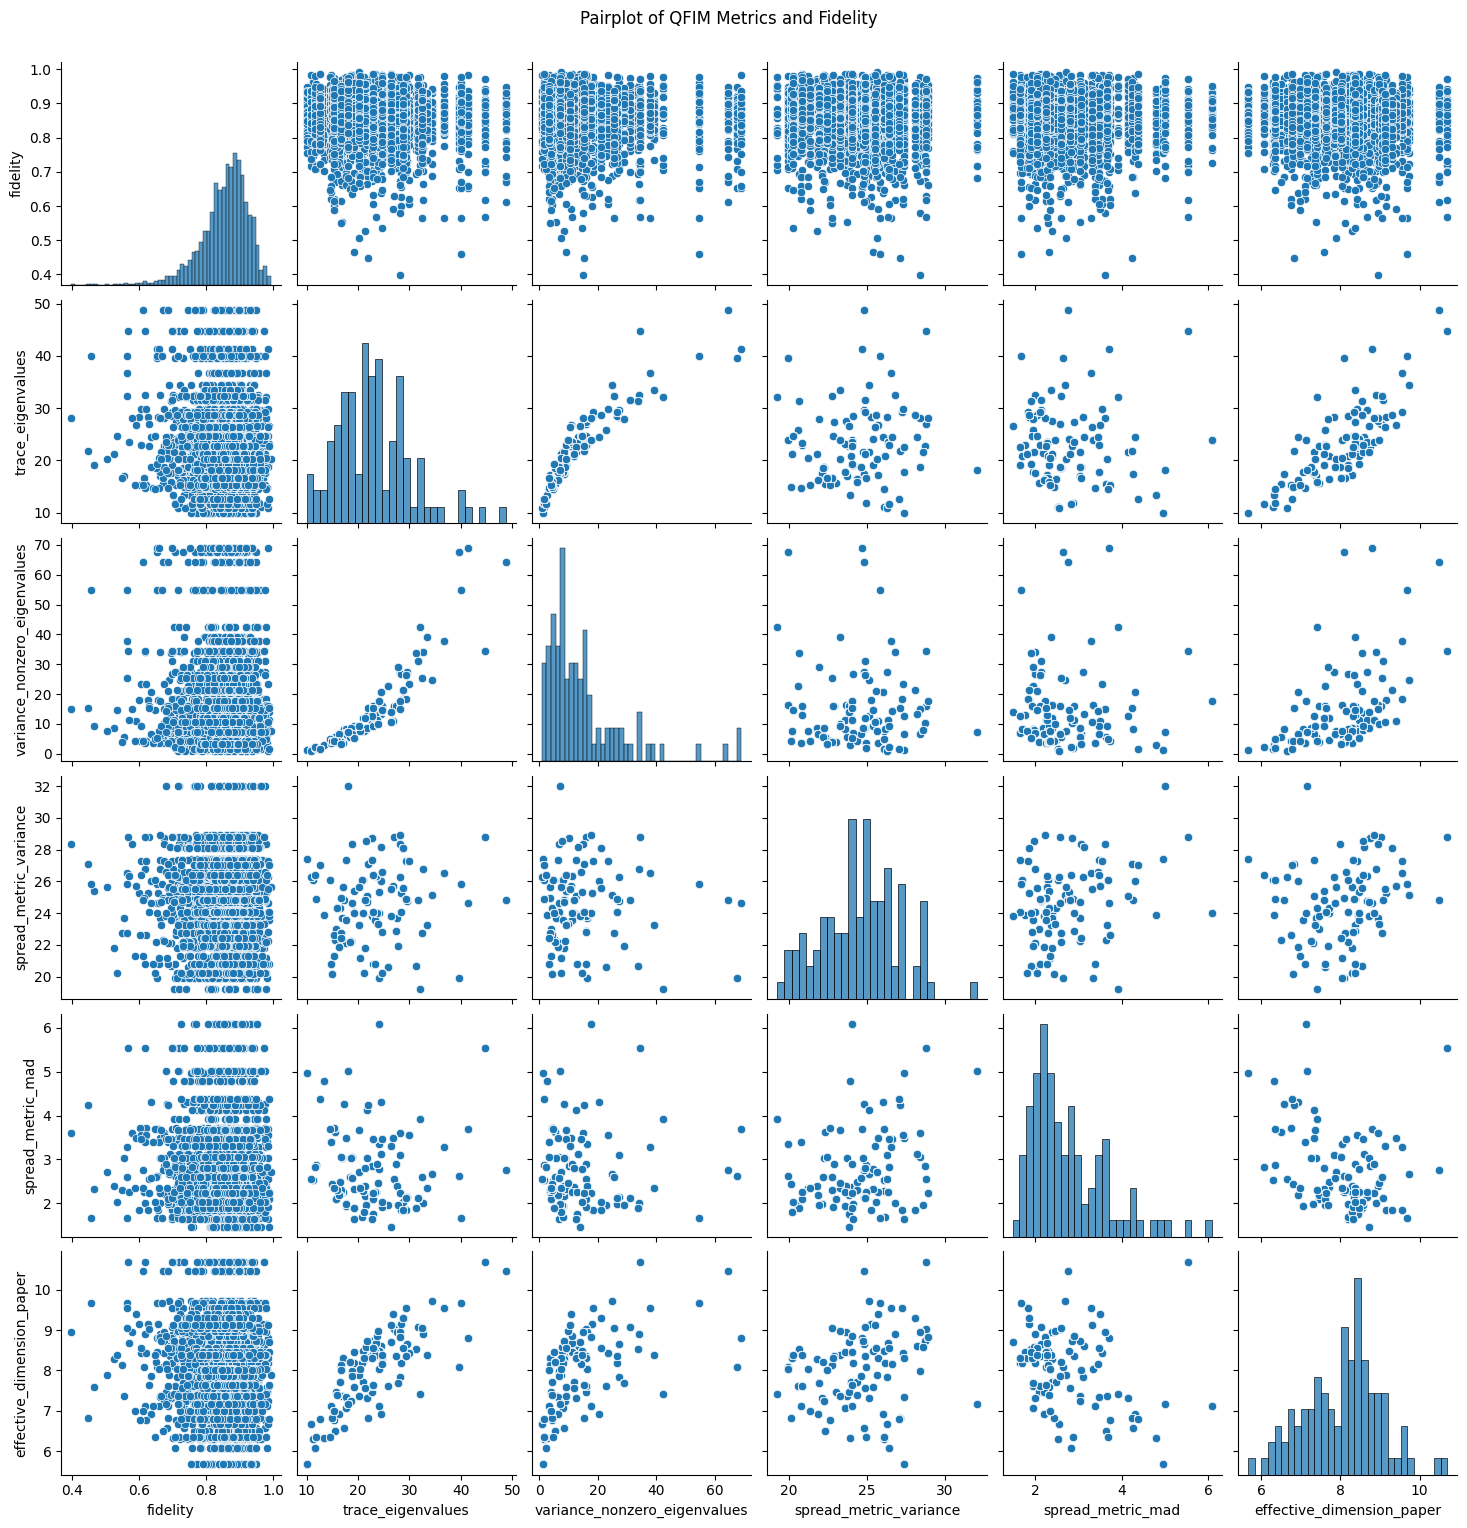

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    'fidelity',         # Averaged fidelity from test results
    'trace_eigenvalues',                # Trace of QFIM
   
    'variance_nonzero_eigenvalues',  # Variance of QFIM eigenvalues (nonzero only)
    
    'spread_metric_variance',      
    'spread_metric_mad',      

    'effective_dimension_paper',  # Effective dimension computed via the paper's formula
    'entropy'               # Entropy of the eigenvalue distribution
]


# 2. Pair Plot
sns.pairplot(df_exploded[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

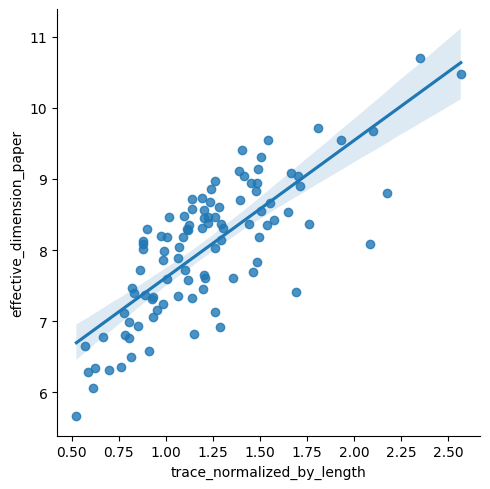

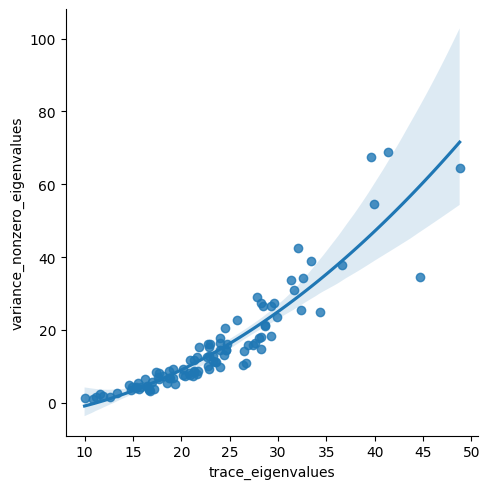

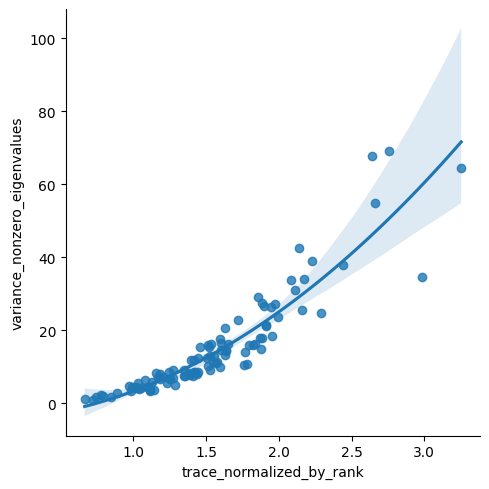

In [92]:
sns.lmplot(x='trace_normalized_by_length', y='effective_dimension_paper', data=df_final, order=1)
sns.lmplot(x='trace_eigenvalues', y='variance_nonzero_eigenvalues', data=df_final, order=2)
sns.lmplot(x='trace_normalized_by_rank', y='variance_nonzero_eigenvalues', data=df_final, order=2)

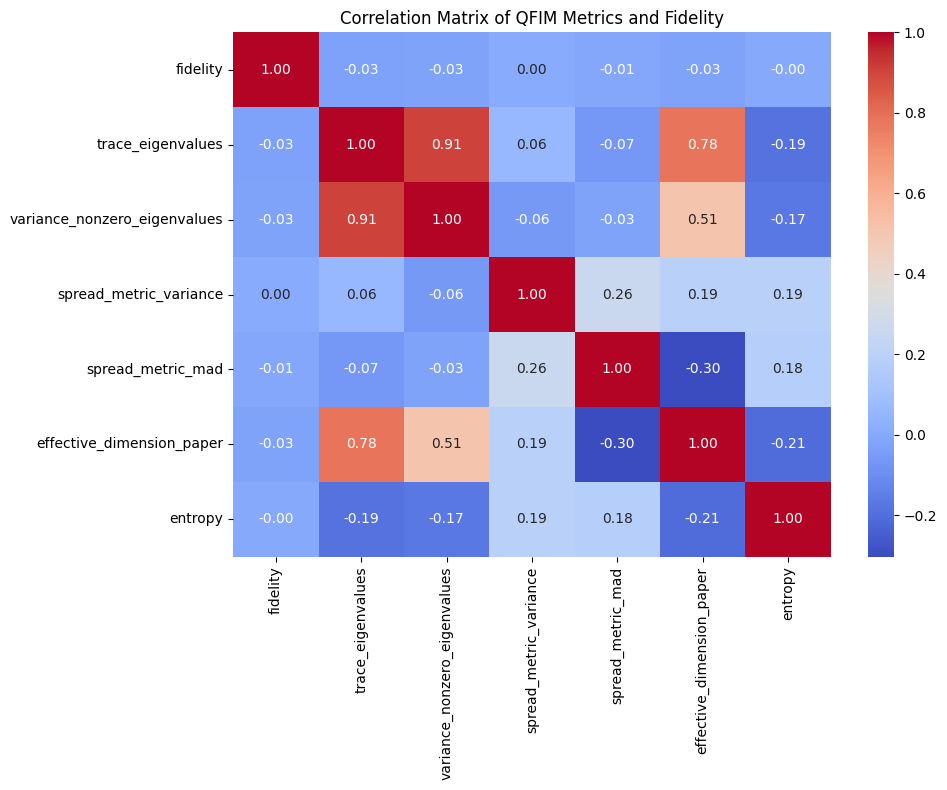

In [132]:
corr_matrix = df_exploded[metrics_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of QFIM Metrics and Fidelity")
plt.tight_layout()
plt.show()

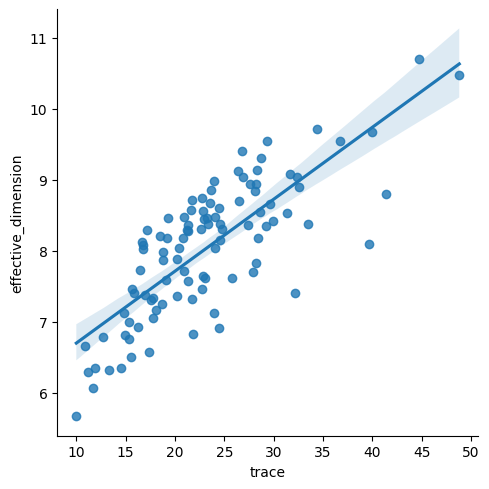

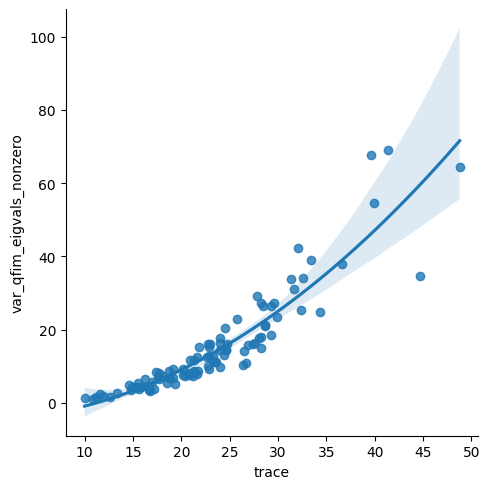

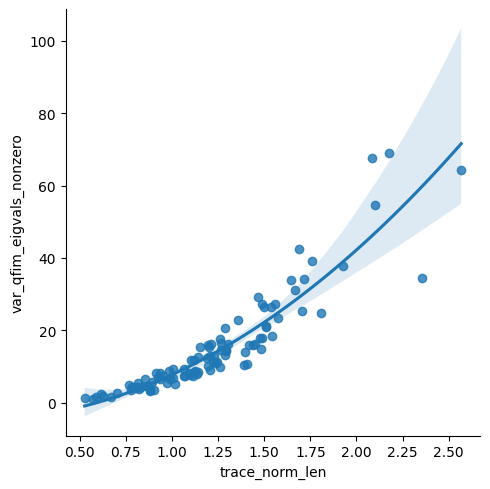

In [78]:
import statsmodels.api as sm

X = df_final[['trace', 'effective_dimension', 'entropy']]  # example
y = df_final['avg_fidelity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

ModuleNotFoundError: No module named 'statsmodels'

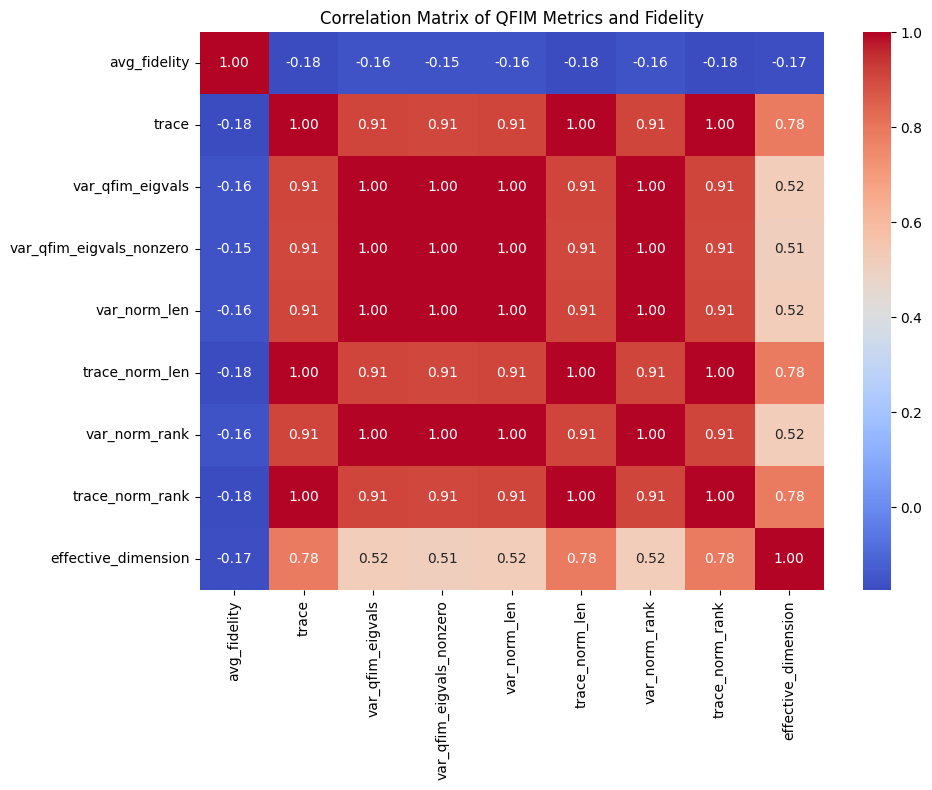

In [ ]:

# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    'trace',                # Trace of QFIM
    'var_qfim_eigvals',      # Variance of QFIM eigenvalues (all)
    'var_qfim_eigvals_nonzero',  # Variance of QFIM eigenvalues (nonzero only)
    'var_norm_len',         # Variance normalized by the total number of eigenvalues
    'trace_norm_len',       # Trace normalized by the total number of eigenvalues
    'var_norm_rank',        # Variance normalized by rank
    'trace_norm_rank',      # Trace normalized by rank
    'effective_dimension',  # Effective dimension computed via the paper's formula
    # 'entropy'               # Entropy of the eigenvalue distribution
]
corr_matrix = df_final[metrics_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of QFIM Metrics and Fidelity")
plt.tight_layout()
plt.show()


In [46]:
import os
import pickle
import numpy as np
import os
import pickle
import numpy as np

def read_data_by_gate_new(fixed_param_name, base_path, train_sizes, sample_label='sample_pi', gate_prefix=None):
    """
    Read experiment results from pickle files stored with the following hierarchy:
    
    base_path/
        trainsize_{train_size}/
            {sample_label}/
                {fixed_param_name}/
                    {test_key}/
                        {gate_folder}/
                            data_run_0.pickle
    
    For each test key, the function collects the 'test_results' (converted to fidelities)
    from the pickle file.

    Parameters
    ----------
    fixed_param_name : str
        The fixed parameter folder name (e.g. 'fixed_params0').
    base_path : str
        The base directory containing the experiment results (e.g., 
        "./param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_10").
    train_sizes : list of int
        A list of training sizes to process (e.g., [10]).
    sample_label : str, optional
        The label of the sample folder (default: "sample_pi").
    gate_prefix : str or None, optional
        If provided, only gate folders that start with this prefix will be processed.
    
    Returns
    -------
    data_by_test_key : dict
        A dictionary mapping each test key to a list of testing results.
    data_by_train_size : dict
        A dictionary mapping each training size to a dictionary (keyed by test key)
        of testing results.
    """
    data_by_test_key = {}
    data_by_train_size = {}

    for train_size in train_sizes:
        # print(f"Processing training size: {train_size}")
        data_by_train_size[train_size] = {}
        data_trainsize = data_by_train_size[train_size]
        
        # Use new folder naming: "trainsize_{train_size}"
        train_folder = f"trainsize_{train_size}"
        train_path = os.path.join(base_path, train_folder, sample_label, fixed_param_name)
        # print(f"Checking train path: {train_path}")
        if not os.path.exists(train_path):
            # print(f"Train path does not exist: {train_path}")
            continue
        
        # Loop over test key folders.
        for test_key in os.listdir(train_path):
            test_key_path = os.path.join(train_path, test_key)
            # print(f"Processing test key: {test_key} at path: {test_key_path}")
            if not os.path.isdir(test_key_path):
                # print(f"Not a directory: {test_key_path}")
                continue
            
            # Loop over gate folders within each test key.
            for gate_folder in sorted(os.listdir(test_key_path)):
                # print(f"Found gate folder: {gate_folder} in test key: {test_key}")
                if gate_prefix is not None and not gate_folder.startswith(gate_prefix):
                    # print(f"Skipping gate folder {gate_folder} because it does not start with {gate_prefix}")
                    continue
                # Construct the full path to the pickle file.
                pickle_file = os.path.join(test_key_path, gate_folder, "data_run_0.pickle")
                # print(f"Looking for pickle file: {pickle_file}")
                if os.path.isfile(pickle_file):
                    try:
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                        # print(f"Loaded file {pickle_file} with keys: {list(df.keys())}")
                        if 'costs' in df and 'test_results' in df:
                            try:
                                costs = [float(cost) for cost in df['costs'][0]]
                            except Exception as e:
                                # print(f"Error converting costs in {pickle_file}: {e}")
                                costs = []
                            try:
                                testing_results = [1 - float(res) for res in df['test_results'][0]]
                            except Exception as e:
                                # print(f"Error converting test_results in {pickle_file}: {e}")
                                testing_results = []
                            if test_key not in data_by_test_key:
                                data_by_test_key[test_key] = []
                            if test_key not in data_trainsize:
                                data_trainsize[test_key] = []
                            data_by_test_key[test_key].extend(testing_results)
                            data_trainsize[test_key].extend(testing_results)
                            # print(f"Stored {len(testing_results)} testing results for test key {test_key}")
                        else:
                            print(f"File {pickle_file} missing keys 'costs' or 'test_results'")
                    except Exception as ex:
                        print(f"Error processing {pickle_file}: {ex}")
                else:
                    print(f"Pickle file does not exist: {pickle_file}")
    return data_by_test_key, data_by_train_size

# Example usage:
fixed_param_name = 'fixed_params0'
base_path = "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_7"
train_sizes = [10,20]
N_ctrl = 2
gate_prefix = f"U{N_ctrl}"  # if you want to only include random gates starting with "U2"
data_by_test_key, data_by_train_size = read_data_by_gate_new(fixed_param_name, base_path, train_sizes, sample_label="sample_pi", gate_prefix=gate_prefix)
# fixed_param_name = 'fixed_params0'
# base_path = "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_10"
# train_sizes = [10]
# gate_prefix = "U2"  # if you want to only include random gates starting with "U2"
# data_by_test_key, data_by_train_size = read_data_by_gate_new(fixed_param_name, base_path, train_sizes, sample_label="sample_pi", gate_prefix=gate_prefix)

In [51]:
data_by_test_key['test27']

[0.7177394206475822,
 0.8145557243215649,
 0.679678289769161,
 0.7603270770761736,
 0.631268504978164,
 0.7674510130240186,
 0.6000856249610053,
 0.7259723908163362,
 0.7036859074857924,
 0.8155886107840847,
 0.8511167819899208,
 0.741430382823446,
 0.5996843122750333,
 0.8107791021693546,
 0.6516243858256943,
 0.7119324427750728,
 0.7286762538283228,
 0.6984865995318033,
 0.5460959601503815,
 0.7514884649356935,
 0.6941034359463976,
 0.881711022130531,
 0.5745691031908211,
 0.6648435736165268,
 0.618872805106116,
 0.8634828033964737,
 0.856458669695836,
 0.8018493033013288,
 0.6573586583722762,
 0.9235671454930641,
 0.8057854083141947,
 0.8415004911858063,
 0.7841354217959368,
 0.7424677686362007,
 0.5748311641242704,
 0.8155337370921083,
 0.6957907007900521,
 0.8370541188478565,
 0.5627168531022759,
 0.7768826980734624,
 0.6503878248382,
 0.564378585475264,
 0.6805122012814592,
 0.6850601104847839,
 0.8197301261657124,
 0.5812047447702462,
 0.8878797530119886,
 0.6025523539506183,
 0

[('test79', 0.816843306538713), ('test47', 0.8175522854811504), ('test32', 0.8264311553352902), ('test39', 0.8324457143287365), ('test84', 0.8372722942861913), ('test46', 0.8401577166959078), ('test2', 0.8403192814269106), ('test27', 0.8445245259535161), ('test45', 0.8470314847795185)]


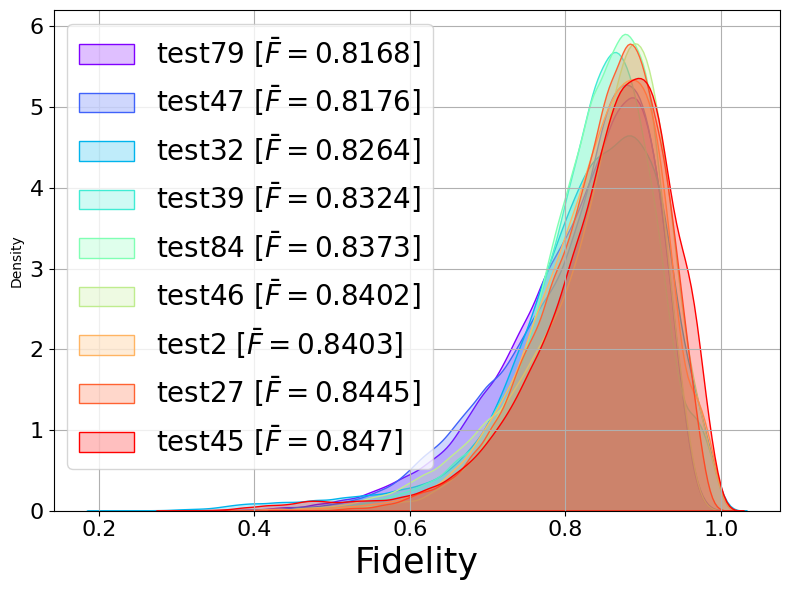

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Function to plot combined KDE of fidelity distributions with average fidelity scores
def plot_combined_kde_fidelity(data_by_test_key, fixed_param_name, include=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True, zorder=10)
    min_val = np.inf
    # Plot KDE for each test_key with a different color
    plot_results, plot_results_sorted = {}, {}

    # Filter and collect fidelities
    for test_key, fidelities in data_by_test_key.items():
        if include is None or test_key in include:
            temp_min = min(fidelities)
            if temp_min < min_val:
                min_val = temp_min
            plot_results[test_key] = fidelities
            plot_results_sorted[test_key] = np.mean(fidelities)

    # Sort by average fidelities
    plot_results_sorted = sorted(plot_results_sorted.items(), key=lambda x: float(np.mean(x[1])))
    print(plot_results_sorted)

    # Create a colormap based on the number of tests to display
    cmap = plt.get_cmap('rainbow', len(plot_results_sorted))
    
    # Assign colors using the rainbow colormap
    colors = {test_key: cmap(i) for i, (test_key, _) in enumerate(plot_results_sorted)}

    # Plot each test's KDE with the corresponding color
    for i, (test_key, avg_fidelity) in enumerate(plot_results_sorted):
        fidelities = plot_results[test_key]
        sns.kdeplot(fidelities, ax=ax, fill=True, multiple="layer", 
                    color=colors[test_key], label=test_key + f" [$\\bar{{F}} = {round(avg_fidelity,4)}$]")

    # Customize plot
    ax.set_xlabel('Fidelity', fontsize=25)
    # ax.set_xlim(min_val+0.2, 1.05)
    # ax.set_title(f'QFIM Param Init KDE distribution  (50x Random {N_ctrl}-qubit Unitary)', fontsize=28)
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()
display =  ['test6','test82','test79','test66','test13','test4']
display = ['test79', 'test47','test46','test32', 'test2','test39','test27','test45','test84']
# plot_combined_kde_fidelity(data_by_train_size[10], fixed_param_name, include=display)
plot_combined_kde_fidelity(data_by_train_size[20], fixed_param_name, include=display)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot combined KDE of fidelity distributions with average fidelity scores
def plot_combined_kde_fidelity(data_by_test_key, fixed_param_name, include=None):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.grid(True, zorder=10)
    min_val = np.inf
    # Plot KDE for each test_key with a different color
    plot_results, plot_results_sorted = {}, {}

    # Filter and collect fidelities
    for test_key, fidelities in data_by_test_key.items():
        if include is None or test_key in include:
            temp_min = min(fidelities)
            if temp_min < min_val:
                min_val = temp_min
            plot_results[test_key] = fidelities
            plot_results_sorted[test_key] = np.mean(fidelities)

    # Sort by average fidelities
    plot_results_sorted = sorted(plot_results_sorted.items(), key=lambda x: float(np.mean(x[1])))
    print(plot_results_sorted)

    # Create a colormap based on the number of tests to display
    cmap = plt.get_cmap('rainbow', len(plot_results_sorted))
    
    # Assign colors using the rainbow colormap
    colors = {test_key: cmap(i) for i, (test_key, _) in enumerate(plot_results_sorted)}

    # Plot each test's KDE with the corresponding color
    for i, (test_key, avg_fidelity) in enumerate(plot_results_sorted):
        fidelities = plot_results[test_key]
        sns.kdeplot(fidelities, ax=ax, fill=True, multiple="layer", 
                    color=colors[test_key], label=test_key + f" [$\\bar{{F}} = {round(avg_fidelity,4)}$]")

    # Customize plot
    ax.set_xlabel('Fidelity', fontsize=25)
    # ax.set_xlim(min_val+0.2, 1.05)
    ax.set_title(f'QFIM Param Init KDE distribution  (50x Random {N_ctrl}-qubit Unitary)', fontsize=28)
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()
display =  ['test18','test89','test172','test73','test35','test196','test139','test15', 'test118','test82','test146','test170' ]
# Example display list and call
# display =['test75', 'test86', 'test44','test5','test141','test133','test130','test190','test141','test165','test66','test58']
# display = ['test110','test20',  'test22', 'test5', 'test67', 'test7','test84','test103']
plot_combined_kde_fidelity(data_trainsize2[10], fixed_param_name, include=display)

In [ ]:
# Function to compute mean and standard deviation for each epoch across all gates for each test key
def compute_cost_statistics(data_by_test_key, epochs_to_show):
    statistics = {}
    for test_key, gates in data_by_test_key.items():
        print(gates)
        mean_costs = []
        std_costs = []
        for epoch in range(epochs_to_show):
            epoch_costs = [costs[epoch] for costs in gates.values() if len(costs) > epoch]
            if epoch_costs:
                mean_costs.append(np.mean(epoch_costs))
                std_costs.append(np.std(epoch_costs))
        statistics[test_key] = (range(len(mean_costs)), mean_costs, std_costs)
    return statistics

# Function to plot cost history with standard deviation for each test key
def plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=None, epochs_to_show=None):
    # Filter test keys based on include argument
    if include is not None:
        data_by_test_key = {k: v for k, v in data_by_test_key.items() if k in include}

    # Determine the number of epochs to show
    if epochs_to_show is None:
        epochs_to_show = min(len(costs) for gates in data_by_test_key.values() for costs in gates.values())

    statistics = compute_cost_statistics(data_by_test_key, epochs_to_show)

    plt.figure(figsize=(10, 6))

    for test_key in include:
        """
        if test_key == 'test56':
            label_str = r"max($Tr(\mathcal{Q})$)"
        elif test_key == 'test3':
            label_str = r"max($Tr(\mathcal{Q})$) 2nd"
        elif test_key == 'test65':
            label_str = r"min($Tr(\mathcal{Q})$) 2nd"

        else:
            label_str = r"min($Tr(\mathcal{Q})$)"
        """
        label_str = test_key
        epochs, mean_costs, std_costs = statistics[test_key]
        plt.plot(epochs, mean_costs, label=label_str)
        plt.fill_between(epochs, np.array(mean_costs) - np.array(std_costs), np.array(mean_costs) + np.array(std_costs), alpha=0.2)

    plt.xlabel('Epochs',fontsize = 20)
    plt.ylabel('Infidelity',fontsize = 20)
    #plt.title(f'Cost History with Standard Deviation for {fixed_param_name}')
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Plot with specific test keys and a limited number of epochs
include_keys = ['test20', 'test22', 'test110','test103', 'test5','test52', 'test116', 'test13', 'test113']
epochs_to_show = 1500

plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=include_keys, epochs_to_show=epochs_to_show)